In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

In [2]:
ind=np.load('bin_seg.npy')
ni = np.load('ni_bin_seg.npy')

In [4]:
cv2.imshow('ab',ni)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [6]:
ni_contours_final, _, ni_list_ratioArea_final, ni_list_grainArea_final = findratioarea(ni)

In [8]:
len(ni_contours_final)

1095

In [10]:
in_contours_final, _, in_list_ratioArea_final, in_list_grainArea_final = findratioarea(ind)

In [11]:
len(in_contours_final)

1371

In [15]:
ni_contours_final.append(0)

AttributeError: 'tuple' object has no attribute 'append'

In [12]:
type(in_contours_final)

tuple

In [6]:
type(ni)

numpy.ndarray

In [1]:
a=(1,2)
a.append(3)

AttributeError: 'tuple' object has no attribute 'append'

In [20]:
def show_image(grayscale_image,wn):
    cv2.namedWindow(wn, cv2.WINDOW_NORMAL)  # Create a resizable window
    cv2.resizeWindow(wn, grayscale_image.shape[1], grayscale_image.shape[0])  # Resize to the image dimensions
    cv2.imshow(wn, grayscale_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()




In [21]:
def watershed(binary, factor_distance):
    binary_BGR = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)
    dist_watershed = cv2.distanceTransform(binary, cv2.DIST_L2, 5)
    ret, foreground = cv2.threshold(dist_watershed, dist_watershed.max() * factor_distance, 255, cv2.THRESH_BINARY)
    foreground = np.uint8(foreground)
    kernel_foreground = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    foreground = cv2.morphologyEx(foreground, cv2.MORPH_OPEN, kernel_foreground)
    unknown = cv2.subtract(binary, foreground)
    _, labels = cv2.connectedComponents(foreground)
    labels = labels + 1
    labels[unknown == 255] = 0
    labels = cv2.watershed(binary_BGR, labels)
    binary[labels == -1] = 0
    return binary



In [5]:
def findratioarea( binary):
    #Find adhesion areas based on area ratio
    contours, hierarchy = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    list_grainArea = []
    list_convexArea = []
    list_ratioArea = []

    for i in range(len(contours)):
        grainArea = cv2.contourArea(contours[i])
        list_grainArea.append(grainArea)
        hull = cv2.convexHull(contours[i])
        convexArea = cv2.contourArea(hull)
        list_convexArea.append(convexArea)

    for i in range(len(contours)):
        if list_convexArea[i] != 0:
            ratioArea = list_grainArea[i] / list_convexArea[i]
        else:
            ratioArea = 0
        list_ratioArea.append(ratioArea)
    return contours, hierarchy, list_ratioArea, list_grainArea


In [23]:
def findThreshold( binary):
    
    print('findThreshold')
    array_1D = binary.ravel()
    se = pd.Series(array_1D)
    grayvalue_counts = dict(se.value_counts(sort=False))

    for k in list(grayvalue_counts.keys()):
        if grayvalue_counts[k] <= 1000:
            del grayvalue_counts[k]

    grayvalue = list(grayvalue_counts.keys())
    counts = list(grayvalue_counts.values())

    counts_normal = []
    for i in range(len(counts)):
        Max = max(counts)
        Min = min(counts)
        counts_normal.append((counts[i] - Min) / (Max - Min))

    counts_sup = [0 for _ in range(256)]
    for i in range(0, 256):
        for j in range(0, len(grayvalue)):
            if grayvalue[j] == i:
                counts_sup[i] = counts_normal[j]

    peakindex = signal.find_peaks_cwt(counts_sup, (15, 15))
    if len(peakindex) >= 2:
        thre_left = peakindex[0]
        peakindex_different = []
        for i in range(0, len(peakindex)):
            peakindex_different.append(abs(peakindex[i] - 200))
        thre_right = peakindex[peakindex_different.index(min(peakindex_different))]
        num_0_middle = counts_sup[thre_left:thre_right].count(0)

        list_0_middle = []
        if num_0_middle != 0:
            for i in range(thre_left, thre_right):
                if counts_sup[i] == 0:
                    list_0_middle.append(i)
            thre = int((list_0_middle[0] + 1.6 * list_0_middle[-1]) / 3)
        else:
            thre = 55
    else:
        thre = 55

    return thre

In [24]:
def findshapefactor(binary):
    #Determine seed shape based on shape factor
    print('findshapefactor')
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    list_grainarea = []
    list_grainArea = []
    list_grainPerimeter = []
    list_shapeFactor = []
    list_longEdge = []
    list_shortEdge = []

    for i in range(len(contours)):
        grainArea = cv2.contourArea(contours[i])
        grainPerimeter = cv2.arcLength(contours[i], True)
        list_grainarea.append(grainArea)
        list_grainArea.append(4 * 3.141592653 * grainArea)
        list_grainPerimeter.append(grainPerimeter ** 2)

        rect = cv2.minAreaRect(contours[i])
        if rect[1][0] >= rect [1][1]:
            list_longEdge.append(rect[1][0])
            list_shortEdge.append(rect[1][1])

        else:
            list_longEdge.append(rect[1][1])
            list_shortEdge.append(rect[1][0])

    longEdge = np.mean(list_longEdge)

    if list_shortEdge == []:
        shortEdge = 40
    else:
        shortEdge = np.mean(list_shortEdge)

    for i in range(len(contours)):
        try:
            shapeFactor = list_grainArea[i] / list_grainPerimeter[i]
            list_shapeFactor.append(shapeFactor)
        except:
            list_shapeFactor.append(0)

    return contours, list_shapeFactor, list_grainarea, longEdge, shortEdge



In [25]:
def segmentation( binary, factor_distance_1, factor_distance_2, ratioarea, factor,slf_kernel,slf_area_checkshape):
    print('segmentation')
    binary_seg = np.zeros(binary.shape, dtype=np.uint8)
    for i in (factor_distance_1, factor_distance_2):
        binary_seg_watershed = watershed(binary, i / 10)
        kernel_watersged = cv2.getStructuringElement(cv2.MORPH_RECT, (factor, factor))
        binary_seg_watershed = cv2.morphologyEx(binary_seg_watershed, cv2.MORPH_OPEN, kernel_watersged, iterations=2)
        binary_seg_watershed = cv2.erode(binary_seg_watershed, slf_kernel)

        contours, _, list_ratioArea, list_grainArea = findratioarea(binary_seg_watershed)
        binary_adhesion_watershed = binary_seg_watershed.copy()
        binary_single_watershed = binary_seg_watershed.copy()

        if slf_area_checkshape >= 1000:
            for i in range(len(contours)):
                if list_ratioArea[i]:
                    if list_ratioArea[i] <= ratioarea or list_grainArea[i] >= 1.4 * np.mean(list_grainArea):
                        cv2.drawContours(binary_single_watershed, [contours[i]], 0, 0, -1)
                    else:
                        cv2.drawContours(binary_adhesion_watershed, [contours[i]], 0, 0, -1)
                else:
                    pass
        else:
            for i in range(len(contours)):
                if list_ratioArea[i]:
                    if list_ratioArea[i] <= ratioarea and list_grainArea[i] >= 1.4 * np.mean(list_grainArea):
                        cv2.drawContours(binary_single_watershed, [contours[i]], 0, 0, -1)
                    else:
                        cv2.drawContours(binary_adhesion_watershed, [contours[i]], 0, 0, -1)
                else:
                    pass

        binary = cv2.dilate(binary_adhesion_watershed, slf_kernel)
        binary_seg = cv2.add(binary_single_watershed, binary_seg)

    return binary_seg, binary_adhesion_watershed

In [26]:
def shapeFactorAndArea( list, way):
    print('shapeFactorAndArea has kmeans')
    list.sort()
    for i in range(len(list)):
        list[i] = round(list[i], 2)

    if len(list) >= 3:
        kmeans = KMeans(n_clusters = 3)
    elif len(list) == 2:
        kmeans = KMeans(n_clusters= 2 )
    else:
        kmeans = KMeans(n_clusters= 1 )

    list_reshape = np.array(list).reshape(-1, 1)
    kmeans.fit(list_reshape)
    list_single = []

    if way == 0:
        for i in range(len(list)):
            if kmeans.labels_[i] == kmeans.labels_[-1]:
                list_single.append(list[i])
    else:
        for i in range(len(list)):
            if kmeans.labels_[i] == kmeans.labels_[0]:
                list_single.append(list[i])

    return np.mean(list_single)

In [ ]:
def segmentation_next( binary_adhesion, contours_adhesion,slf_shapeFactor_checkshape):
    print('segmentation_next')
    binary_adhesion_next = np.zeros((binary_adhesion.shape[0], binary_adhesion.shape[1]), np.uint8)
    for i in range(0, len(contours_adhesion)):
        binary_adhesion_Single = np.zeros((binary_adhesion.shape[0], binary_adhesion.shape[1]), np.uint8)
        cv2.drawContours(binary_adhesion_Single, [contours_adhesion[i]], 0, 255, -1)
        binary_adhesion_Single = cv2.bitwise_and(binary_adhesion, binary_adhesion_Single)

        contours, _ = cv2.findContours(binary_adhesion_Single, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        x_cut, y_cut, w_cut, h_cut = cv2.boundingRect(contours[0])

        w_Cut, h_Cut = w_cut + 10, h_cut + 10
        if y_cut < 10:
            y_cut = 10
        if y_cut > binary_adhesion_Single.shape[0] - h_Cut:
            y_cut = binary_adhesion_Single.shape[0] - h_Cut
        if x_cut < 10:
            x_cut = 10
        if x_cut > binary_adhesion_Single.shape[1] - w_Cut:
            x_cut = binary_adhesion_Single.shape[1] - w_Cut
        binary_adhesion_single = binary_adhesion_Single[y_cut - 10: y_cut + h_Cut, x_cut - 10: x_cut + w_Cut]

        dst_cornerHarris = cv2.cornerHarris(binary_adhesion_single, 2, 23, 0.02)
        binary_adhesion_line = binary_adhesion_single.copy()
        binary_adhesion_line[dst_cornerHarris > 1e-13 * dst_cornerHarris.max()] = 255
        binary_adhesion_segline = cv2.subtract(binary_adhesion_line, binary_adhesion_single)
        num_linepixel = len(binary_adhesion_segline[binary_adhesion_segline == 255])
        binary_adhesion_segline = cv2.dilate(binary_adhesion_segline, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)))

        if num_linepixel >= 25:
            lines = cv2.HoughLinesP(binary_adhesion_segline, 2, np.pi / 180, 25, minLineLength = 10, maxLineGap = 30)
        else:
            lines = cv2.HoughLinesP(binary_adhesion_segline, 2, np.pi / 180, 15, minLineLength = 8, maxLineGap = 30)

        if lines is None:
            binary_adhesion_next = cv2.add(binary_adhesion_next, binary_adhesion_Single)
        else:

            binary_adhesion_Line = cv2.cvtColor(binary_adhesion_line, cv2.COLOR_GRAY2BGR)
            for line in lines:
                x1, y1, x2, y2 = line[0]
                cv2.line(binary_adhesion_Line, (x1, y1), (x2, y2), (0, 255, 0), 1)

            for line in lines:
                x1_reference, y1_reference, x2_reference, y2_reference = line[0]
                distance = ((x1_reference - x2_reference) ** 2 + (y1_reference - y2_reference) ** 2) ** 0.5
                if distance <= 100:
                    break

            list_x1 = []
            list_x2 = []
            list_y1 = []
            list_y2 = []
            for line in lines:
                x1, y1, x2, y2 = line[0]
                if abs(x1 - x1_reference) < 10 and abs(y1 - y1_reference) < 10 and abs(
                        x2 - x2_reference) < 10 and abs(y2 - y2_reference) < 10:
                    list_x1.append(x1)
                    list_x2.append(x2)
                    list_y1.append(y1)
                    list_y2.append(y2)

            x1_line = int(np.mean(list_x1))
            y1_line = int(np.mean(list_y1))
            x2_line = int(np.mean(list_x2))
            y2_line = int(np.mean(list_y2))

            binary_adhesion_SINGLE= cv2.cvtColor(binary_adhesion_single, cv2.COLOR_GRAY2BGR)
            cv2.line(binary_adhesion_SINGLE, (x1_line, y1_line), (x2_line, y2_line), (0, 255, 0), 2)

            if x2_line == x1_line:
                x2_line = x1_line + 1

            k = (y2_line - y1_line) / (x2_line - x1_line)
            b = (x1_line * y2_line - x2_line * y1_line) / (x1_line - x2_line)
            w_cut = w_cut + 10
            h_cut = h_cut + 10
            if abs(k) <= 1:
                if (x1_line - x2_line) < 0:
                    if slf_shapeFactor_checkshape <= 0.75:
                        i, j = 2, 2
                    else:
                        i, j = 5, 5

                    while x1_line - i > 10 and int(k * (x1_line - i) + b) > 10 and x1_line - i < w_cut and int(
                            k * (x1_line - i) + b) < h_cut and binary_adhesion_single[
                        int(k * (x1_line - i) + b), x1_line - i].tolist() == 255:
                        binary_adhesion_single[int(k * (x1_line - i) + b), x1_line - i] = 0
                        i += 1

                    while x2_line + j > 10 and int(k * (x2_line + j) + b) > 10 and x2_line + j < w_cut and int(
                            k * (x2_line + j) + b) < h_cut and binary_adhesion_single[
                        int(k * (x2_line + j) + b), x2_line + j].tolist() == 255:
                        binary_adhesion_single[int(k * (x2_line + j) + b), x2_line + j] = 0
                        j += 1

                    x1_seg = x1_line - i
                    y1_seg = int(k * (x1_line - i) + b)
                    x2_seg = x2_line + j
                    y2_seg = int(k * (x2_line + j) + b)

                else:
                    if slf_shapeFactor_checkshape <= 0.75:
                        i, j = 2, 2
                    else:
                        i, j = 5, 5

                    while x1_line + i > 10 and int(k * (x1_line + i) + b) > 10 and x1_line + i < w_cut and int(
                            k * (x1_line + i) + b) < h_cut and binary_adhesion_single[
                        int(k * (x1_line + i) + b), x1_line + i].tolist() == 255:
                        binary_adhesion_single[int(k * (x1_line + i) + b), x1_line + i] = 0
                        i += 1
                    while x2_line - j > 10 and int(k * (x2_line - j) + b) > 10 and x2_line - j < w_cut and int(
                            k * (x2_line - j) + b) < h_cut and binary_adhesion_single[
                        int(k * (x2_line - j) + b), x2_line - j].tolist() == 255:
                        binary_adhesion_single[int(k * (x2_line - j) + b), x2_line - j] = 0
                        j += 1

                    x1_seg = x1_line + i
                    y1_seg = int(k * (x1_line + i) + b)
                    x2_seg = x2_line - j
                    y2_seg = int(k * (x2_line - j) + b)

            else:
                if (y1_line - y2_line) < 0:
                    if slf_shapeFactor_checkshape <= 0.75:
                        i, j = 2, 2
                    else:
                        i, j = 5, 5

                    while int((y1_line - i - b) / k) > 10 and y1_line - i > 10 and int(
                            (y1_line - i - b) / k) < w_cut and y1_line - i < h_cut and binary_adhesion_single[
                        y1_line - i, int((y1_line - i - b) / k)].tolist() == 255:
                        binary_adhesion_single[y1_line - i, int((y1_line - i - b) / k)] = 0
                        i += 1
                    while int((y2_line + j - b) / k) > 10 and y2_line + j > 10 and int(
                            (y2_line + j - b) / k) < w_cut and y2_line + j < h_cut and binary_adhesion_single[
                        y2_line + j, int((y2_line + j - b) / k)].tolist() == 255:
                        binary_adhesion_single[y2_line + j, int((y2_line + j - b) / k)] = 0
                        j += 1

                    x1_seg = int((y1_line - i - b) / k)
                    y1_seg = y1_line - i
                    x2_seg = int((y2_line + j - b) / k)
                    y2_seg = y2_line + j

                else:
                    if slf_shapeFactor_checkshape <= 0.75:
                        i, j = 2, 2
                    else:
                        i, j = 5, 5

                    while int((y1_line + i - b) / k) > 10 and y1_line + i > 10 and int(
                            (y1_line + i - b) / k) < w_cut and y1_line + i < h_cut and binary_adhesion_single[
                        y1_line + i, int((y1_line + i - b) / k)].tolist() == 255:
                        binary_adhesion_single[y1_line + i, int((y1_line + i - b) / k)] = 0
                        i += 1
                    while int((y2_line - j - b) / k) > 10 and y2_line - j > 10 and int(
                            (y2_line - j - b) / k) < w_cut and y2_line - j < h_cut and binary_adhesion_single[
                        y2_line - j, int((y2_line - j - b) / k)].tolist() == 255:
                        binary_adhesion_single[y2_line - j, int((y2_line - j - b) / k)] = 0
                        j += 1

                    x1_seg = int((y1_line + i - b) / k)
                    y1_seg = y1_line + i
                    x2_seg = int((y2_line - j - b) / k)
                    y2_seg = y2_line - j

            x1_seg = x1_seg + x_cut - 10
            y1_seg = y1_seg + y_cut - 10
            x2_seg = x2_seg + x_cut - 10
            y2_seg = y2_seg + y_cut - 10

            # binary_adhesion_Single= cv2.cvtColor(binary_adhesion_Single, cv2.COLOR_GRAY2BGR)
            # cv2.line(binary_adhesion_Single, (x1_seg, y1_seg), (x2_seg, y2_seg), (0, 255, 0), 2)
            # binary_adhesion_Single = cv2.cvtColor(binary_adhesion_Single, cv2.COLOR_BGR2GRAY)
            cv2.line(binary_adhesion_Single, (x1_seg, y1_seg), (x2_seg, y2_seg), 0, 2)
            binary_adhesion_next = cv2.add(binary_adhesion_next, binary_adhesion_Single)

    return binary_adhesion_next

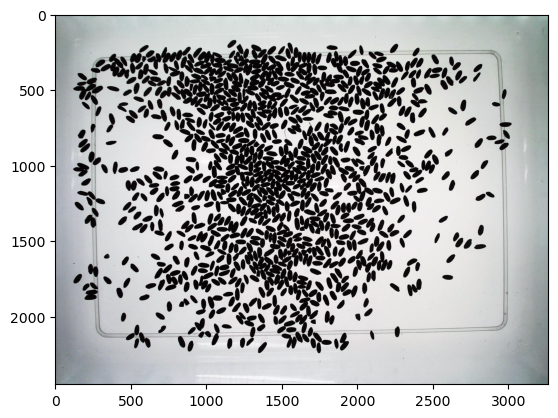

In [19]:
###chinese
image= cv2.imread('sample/30194218.jpg')
plt.imshow(image)
image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
channel_B, G, R = cv2.split(image)
show_image(channel_B,'cb')
# Determine the Background Color
_, binary_background = cv2.threshold(channel_B, 100, 255, cv2.THRESH_BINARY_INV)
show_image(binary_background,'bin')


In [21]:
def process(path,mode=None):
    #### program variables (self)
    slf_widthRatio=-1
    slf_heightRatio=-1
    slf_grainModel =0
    slf_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))


    ####
    inp_path = path
    channel_B = cv2.imread(inp_path, cv2.IMREAD_GRAYSCALE)
    _, binary_background = cv2.threshold(channel_B, 100, 255, cv2.THRESH_BINARY_INV)
    thre = findThreshold(channel_B)

    area_max = 0
    contours, _ = cv2.findContours(binary_background, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    for i in range(1, len(contours)):
        area = cv2.contourArea(contours[i])
        if  area >= area_max:
            area_max = area
    if area_max <= 6000000 * slf_widthRatio * slf_heightRatio:
        _, binary = cv2.threshold(channel_B, thre, 255, cv2.THRESH_BINARY_INV)
    else:
        _, binary = cv2.threshold(channel_B, thre, 255, cv2.THRESH_BINARY)

    # Red box screenshot
    ### checked in main code , this red box ss will go into else aand except
    if slf_widthRatio == 1 and slf_heightRatio == 1:
        pass
    else:
        try:
            binary_mask = np.zeros((binary.shape[0], binary.shape[1]), np.uint8)
            binary_mask[y1 : y2, x1 : x2] = 255
            binary = cv2.bitwise_and(binary, binary_mask)
        except:
            pass
    
    # Remove small noise points
    
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for i in range(len(contours)):
        area = cv2.contourArea(contours[i])
        if area <= 50:
            cv2.drawContours(binary, [contours[i]], -1, 0, -1)


    if slf_grainModel ==0 :
        binary_seg_shape = binary.copy()
        binary_seg_shape = watershed(binary_seg_shape, 0.3)
        binary_seg_shape = cv2.morphologyEx(binary_seg_shape, cv2.MORPH_OPEN, slf_kernel, iterations=2)
        binary_seg_shape = cv2.erode(binary_seg_shape, slf_kernel)

        contours_shape, _, _, list_grainArea_shape = findratioarea(binary_seg_shape )
        if len(list_grainArea_shape) != 0:
            for i in range(len(list_grainArea_shape)):
                if list_grainArea_shape[i] <= 0.1 * np.mean(list_grainArea_shape):
                    cv2.drawContours(binary_seg_shape, [contours_shape[i]], 0, 0, -1)

        _, list_shapeFactor_checkshape, list_grainArea, slf_longEdge, slf_shortEdge = findshapefactor(binary_seg_shape)
        slf_shapeFactor_checkshape = shapeFactorAndArea(list_shapeFactor_checkshape,0)
        slf_area_checkshape = shapeFactorAndArea(list_grainArea,1)

        if slf_shapeFactor_checkshape <= 0.7:
            slf_binary_erode = cv2.erode(binary, cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2)))
        else:
            slf_binary_erode = binary

        binary_single = slf_binary_erode.copy()
        contours, _,list_ratioArea, list_grainArea = findratioarea(slf_binary_erode)
        if len(list_ratioArea) != 0:
            for i in range(len(list_ratioArea)):
                if list_ratioArea[i] <= 0.95 and list_grainArea[i] >= 1.2 * slf_area_checkshape:
                    cv2.drawContours(binary_single, [contours[i]], 0, 0, -1)

        binary_adhesion_first = cv2.bitwise_xor(slf_binary_erode, binary_single)
        contours, hierarchy = cv2.findContours(binary_adhesion_first, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
        print(1820)
        if len(contours) != 0:
            if slf_shapeFactor_checkshape >= 0.75:
                if slf_area_checkshape >= 600:
                    binary_seg, binary_adhesion = segmentation(binary_adhesion_first, 4, 5, 0.92, 7,slf_kernel,slf_area_checkshape)
                else:
                    binary_seg, binary_adhesion = segmentation(binary_adhesion_first, 5.5, 6, 0.92, 3,slf_kernel,slf_area_checkshape)

            elif slf_shapeFactor_checkshape >= 0.675 and slf_shapeFactor_checkshape < 0.75:
                if slf_area_checkshape >= 600:
                    binary_seg, binary_adhesion = segmentation(binary_adhesion_first, 2, 4, 0.92, 7,slf_kernel,slf_area_checkshape)
                else:
                    binary_seg, binary_adhesion = segmentation(binary_adhesion_first, 5.5, 6, 0.92, 3,slf_kernel,slf_area_checkshape)
            else:
                if slf_area_checkshape >= 600:
                    binary_seg, binary_adhesion = segmentation(binary_adhesion_first, 2, 3, 0.91, 5,slf_kernel,slf_area_checkshape)
                else:
                    binary_seg, binary_adhesion = segmentation(binary_adhesion_first, 5.5, 6, 0.92, 3, slf_kernel,slf_area_checkshape)

            kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
            binary_adhesion = cv2.dilate(binary_adhesion, kernel_dilate)
            value_adhesion = 1
            list_binary_adhesion = []
            while (value_adhesion == 1):
                contours_adhesion, _ = cv2.findContours(binary_adhesion, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                if len(contours_adhesion) > 0:
                    binary_adhesion = segmentation_next(binary_adhesion, contours_adhesion,slf_shapeFactor_checkshape)
                    binary_adhesion = cv2.morphologyEx(binary_adhesion, cv2.MORPH_OPEN, kernel_dilate)

                    contours, _, _, list_grainarea = findratioarea(binary_adhesion)
                    binary_adhesion_single = binary_adhesion.copy()
                    for i in range(len(contours)):
                        if list_grainarea[i] >= 1.1 * np.mean(list_grainarea):
                            cv2.drawContours(binary_adhesion_single, [contours[i]], 0, 0, -1)
                        else:
                            cv2.drawContours(binary_adhesion, [contours[i]], 0, 0, -1)
                            list_binary_adhesion.append(binary_adhesion)

                    binary_seg = cv2.add(binary_seg, binary_adhesion_single)

                else:
                    value_adhesion = 0

            try:
                binary_adhesion_last = list_binary_adhesion[-2]
                binary_seg = cv2.subtract(binary_seg, binary_adhesion_last)
                binary_adhesion_last = watershed(binary_adhesion_last, 0.8)
                binary_adhesion_last = cv2.morphologyEx(binary_adhesion_last, cv2.MORPH_OPEN, slf_kernel, iterations=2)
                binary_adhesion_last = cv2.erode(binary_adhesion_last, slf_kernel)
                binary_seg = cv2.add(binary_seg, binary_adhesion_last)

            except:
                pass

            binary_single = cv2.morphologyEx(binary_single, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2)))
            binary_seg = cv2.add(binary_single, binary_seg)
        else:
            binary_seg = binary_single


        # Processing of outlier kernels after segmentation (unsplit)
        print('Processing of outlier kernels after segmentation (unsplit)')
        binary_seg = cv2.morphologyEx(binary_seg, cv2.MORPH_OPEN, slf_kernel)
        binary_seg_error = np.zeros((binary_seg.shape[0], binary_seg.shape[1]), np.uint8)
        contours, _,list_ratioarea, list_grainarea = findratioarea(binary_seg)
        for i in range(len(list_ratioarea)):
            if (1 - list_ratioarea[i]) * list_grainarea[i] >= 0.1 * slf_area_checkshape:
                cv2.drawContours(binary_seg_error, [contours[i]], 0, 255, -1)

        binary_seg_correct = cv2.subtract(binary_seg, binary_seg_error)
        contours_adhesion, _ = cv2.findContours(binary_seg_error, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours_adhesion) > 0:
            binary_seg_error_single = segmentation_next(binary_seg_error, contours_adhesion,slf_shapeFactor_checkshape)
            binary_seg_error_single = cv2.morphologyEx(binary_seg_error_single, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)), iterations=2)
        else:
            binary_seg_error_single = np.zeros((binary_seg_error.shape[0], binary_seg_error.shape[1]), np.uint8)
        binary_seg = cv2.add(binary_seg_correct, binary_seg_error_single)
        print('check point')
        binary_seg = process_overseg(binary_seg,0) ### do this function

        binary_BGR = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)
        unknown = cv2.subtract(binary, binary_seg)
        _, labels = cv2.connectedComponents(binary_seg)
        labels = labels + 1
        labels[unknown == 255] = 0
        labels = cv2.watershed(binary_BGR, labels)
        binary_watershed = binary.copy()
        binary_watershed[labels == -1] = 0
        kernel_Dilate = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        binary_seg = cv2.erode(binary_watershed, kernel_Dilate)

        binary_seg = self.process_overseg(binary_seg, 1)
        binary_seg= cv2.bitwise_and(binary, binary_seg)

        num_noseg = 2



    
    # show_image(binary_background,'prcs')
inp_path='sample/30194218.jpg'
process(path=inp_path)

In [18]:
inp_path='sample/1.Bmp'
#img= cv2.imread(inp_path)
img= cv2.imread(inp_path, cv2.IMREAD_GRAYSCALE)
print(img.shape)

show_image(img,'wn')



(2550, 3509)


In [19]:
binary_BGR = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
print(binary_BGR.shape)
show_image(binary_BGR,'wn')

(2550, 3509, 3)


In [7]:
img = cv2.imread('sample/30194218.jpg')


In [8]:
img.shape

(2448, 3264, 3)

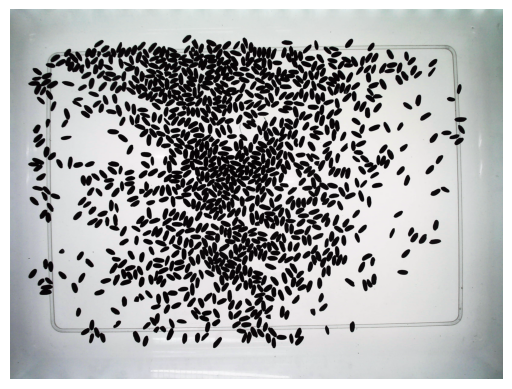

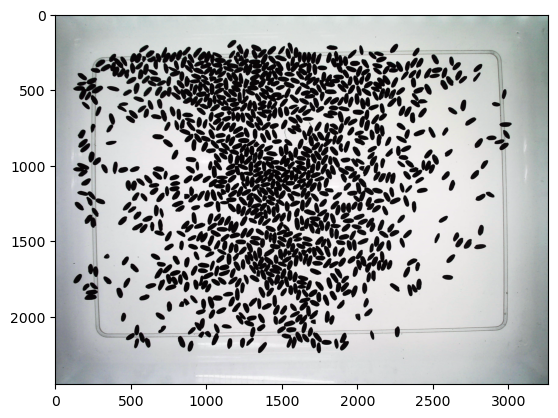

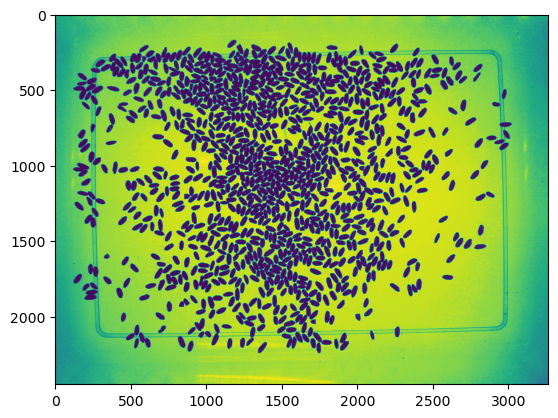

In [23]:
img_name='sample/30194218.jpg'
img=cv2.imdecode(np.fromfile(img_name, dtype=np.uint8), -1)
img_open = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
#img_open = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
plt.imshow(img_open, )

plt.axis( 'off')
plt.show()
plt.imshow(img)
plt.show()
channel_B, _, _ = cv2.split(img_open)


In [24]:
channel_B.shape

(2448, 3264)

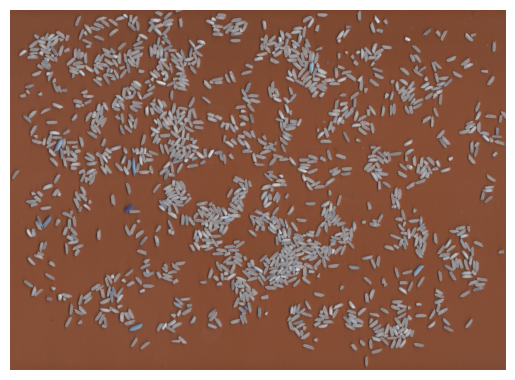

In [21]:
img_name='sample/5.Bmp'
img=cv2.imdecode(np.fromfile(img_name, dtype=np.uint8), -1)
img_open = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
#img_open = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
plt.imshow(img_open, )
plt.axis( 'off')
plt.show()

In [11]:
channel_B, _, _ = cv2.split(img)

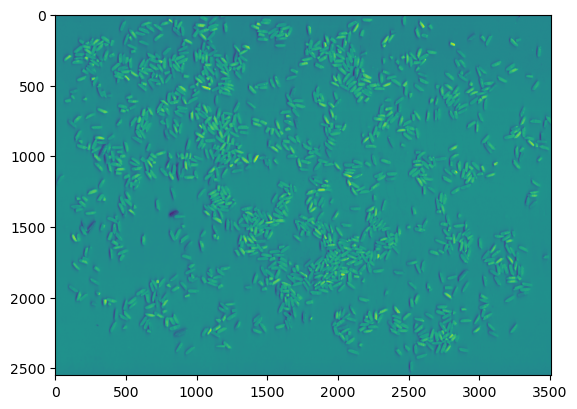

In [12]:
plt.imshow(channel_B)